In [1]:
cd /users/RONDI/project2


/users/RONDI/project2


In [2]:
ls

combined_10000-dataset.txt    labels.npy
combined_1000-dataset.txt     one_hot_data.npy
combined_dataset.txt          postive_nucleotides.txt
final_negative.txt            sampel_neg.txt
labeled_dna_sequences.txt     sampel_posi.txt
labeled_sample_sequences.txt


In [ ]:
import random
import os
print(os.getcwd())


def load_sequences(file_path):
    """Load sequences from a file."""
    with open(file_path, 'r') as file:
        sequences = [line.strip() for line in file if line.strip()]
    return sequences

def sample_sequences(sequences, num_samples):
    """Randomly sample sequences."""
    return random.sample(sequences, num_samples)

def write_labeled_data(output_file, sequences, label):
    """Write sequences with labels to a file."""
    with open(output_file, 'a') as file:
        for seq in sequences:
            file.write(f"{seq.upper()} {label}\n")

def main():
    # File paths
    positive_file = "/users/RONDI/project2/postive_nucleotides.txt"
    negative_file = "/users/RONDI/project2/final_negative.txt"
    output_file = "combined_10000-dataset.txt"
    # output_file = "combined_1000-dataset.txt"

    # Load sequences
    positive_sequences = load_sequences(positive_file)
    negative_sequences = load_sequences(negative_file)

    # Sample 5000 sequences from each
    sampled_positive = sample_sequences(positive_sequences, 5000)
    sampled_negative = sample_sequences(negative_sequences, 5000)

    # sampled_positive = sample_sequences(positive_sequences, 500)
    # sampled_negative = sample_sequences(negative_sequences, 500)

    # Write labeled data
    open(output_file, 'w').close()  # Clear file before writing
    write_labeled_data(output_file, sampled_positive, 1)
    write_labeled_data(output_file, sampled_negative, 0)

    print(f"Data combined and saved to {output_file}")
   

if __name__ == "__main__":
    main()

/users/RONDI/project2
Data combined and saved to combined_10000-dataset.txt


In [33]:
ls

combined_10000-dataset.txt    labels.npy
combined_1000-dataset.txt     one_hot_data.npy
combined_dataset.txt          postive_nucleotides.txt
final_negative.txt            sampel_neg.txt
labeled_dna_sequences.txt     sampel_posi.txt
labeled_sample_sequences.txt


In [3]:

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# !pip install scikit-learn


In [4]:
CLASSES=2
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
class Net(nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=96,kernel_size=11,stride=4)
        self.local_response1=nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2)
        self.pool1 = nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv2 = nn.Conv1d(in_channels=96,out_channels=256,kernel_size=5,padding=2)
        self.local_response2=nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2)
        self.pool2=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv3=nn.Conv1d(in_channels=256,out_channels=384,kernel_size=3,padding=1)
        self.conv4=nn.Conv1d(in_channels=384,out_channels=384,kernel_size=3,padding=1)
        self.conv5=nn.Conv1d(in_channels=384,out_channels=256,kernel_size=3,padding=1)
        self.pool5=nn.MaxPool1d(kernel_size=3,stride=2)
        
        # self.fc1 = nn.Linear(in_features=(256*5),out_features=4096)
        # self.fc2 = nn.Linear(in_features=4096,out_features=4096)
        # self.fc3 = nn.Linear(in_features=4096,out_features=CLASSES)
        
        # Adjust fully connected layers to use hidden_dim
        self.fc1 = nn.Linear(in_features=(256 * 5), out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=CLASSES)

    def forward(self, x):
        x = self.pool1(F.relu(self.local_response1(self.conv1(x))))
        x = self.pool2(F.relu(self.local_response2(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool5(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x
    
class NiN(nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=96,kernel_size=11,stride=4,padding=0)
        self.conv2 = nn.Conv1d(in_channels=96,out_channels=96,kernel_size=1)
        self.conv3=nn.Conv1d(in_channels=96,out_channels=96,kernel_size=1)
        self.pool3 = nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv4=nn.Conv1d(in_channels=96,out_channels=256,kernel_size=11,stride=4,padding=2)
        self.conv5=nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1)
        self.pool5=nn.MaxPool1d(kernel_size=3,stride=2)
        self.conv6=nn.Conv1d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1)        
        self.conv7=nn.Conv1d(in_channels=384,out_channels=384,kernel_size=1)
        self.conv8=nn.Conv1d(in_channels=384,out_channels=384,kernel_size=1)

        # self.fc1 = nn.Linear(in_features=384*2,out_features=512)
        # self.fc2 = nn.Linear(in_features=512,out_features=1024)
        # self.fc3 = nn.Linear(in_features=1024,out_features=CLASSES)

        # Adjust fully connected layers to use hidden_dim
        self.fc1 = nn.Linear(in_features=384 * 2, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=CLASSES)

    def forward(self, x):
        x = F.relu((self.conv1(x)))
        x = F.relu((self.conv2(x)))
        x = self.pool3(F.relu((self.conv3(x))))
        x = F.relu(self.conv4(x))
        x = self.pool5(F.relu(self.conv5(x)))   
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [6]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# File path for the combined dataset
output_file = "combined_10000-dataset.txt"

# Mapping for one-hot encoding: A, T, G, C to binary values
nucleotides = 'ATGC'
one_hot_map = {
    'A': [1, 0, 0, 0],
    'T': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'C': [0, 0, 0, 1]
}

def load_combined_dataset(file_path):
    """Load combined dataset and split sequences and labels."""
    sequences, labels = [], []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            sequences.append(parts[0])  # Sequence
            labels.append(int(parts[1]))  # Label
    return sequences, labels

def one_hot_encode_sequences(sequences):
    """Convert sequences to one-hot encoding."""
    one_hot_data = np.array([
        [one_hot_map[base] for base in sequence] for sequence in sequences
    ])
    return one_hot_data

# Load the combined dataset
sequences, labels = load_combined_dataset(output_file)

# Convert sequences to one-hot encoding
one_hot_data = one_hot_encode_sequences(sequences)

# Rearrange the dimensions to (batch_size, 4, sequence_length)
one_hot_data = one_hot_data.transpose(0, 2, 1)

# Convert to PyTorch tensors
one_hot_tensor = torch.tensor(one_hot_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Optional: Print one-hot encoded sequences
# for i, sequence in enumerate(one_hot_tensor):
#     print(f"Sequence {i+1}: {sequence}")
#     if i >= 5:  # Print only the first 5 sequences for brevity
#         break


# Custom Dataset Class
class DNADataset(Dataset):
    def __init__(self, one_hot_data, labels):
        self.data = one_hot_data  # One-hot encoded sequences
        self.labels = labels      # Corresponding labels

    def __len__(self):
        return len(self.labels)  # Number of samples

    def __getitem__(self, idx):
        # Return a tuple of (one-hot encoded sequence, label)
        return self.data[idx], self.labels[idx]

# Instantiate the custom dataset
dna_dataset = DNADataset(one_hot_tensor, labels_tensor)

# Split dataset into 80% training and 20% testing
train_size = int(0.8 * len(dna_dataset))
test_size = len(dna_dataset) - train_size
train_dataset, test_dataset = random_split(dna_dataset, [train_size, test_size])
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")
# Create a DataLoader
batch_size = 64 # Set batch size according to your preference

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Count total samples in DataLoaders
train_samples = sum(batch[0].shape[0] for batch in train_loader)
test_samples = sum(batch[0].shape[0] for batch in test_loader)

print(f"Samples in train_loader: {train_samples}, Samples in test_loader: {test_samples}")


Training samples: 8000, Testing samples: 2000
Samples in train_loader: 8000, Samples in test_loader: 2000


In [7]:
# Training and Testing Functions
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_samples = 0  # Correctly initialized
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        total_samples += inputs.size(0)  # Track number of samples
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Total training samples: {total_samples}")


def test(model, test_loader, device):
    model.eval()
    total_samples = 0  # Correctly initialized
    correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            total_samples += inputs.size(0)  # Track number of samples
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Total testing samples: {total_samples}")
    return accuracy, y_true, y_pred

In [8]:
for img, classes in train_loader:
    print(img.shape,classes.shape)

torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Size([64])
torch.Size([64, 4, 222]) torch.Siz

Running Net with hidden_dim=512, batch_size=32
Total training samples: 8000
Total testing samples: 2000
Confusion Matrix for Net (h=512, b=32):
[[227 788]
 [193 792]]
Sum of Confusion Matrix Values: 2000
Running Net with hidden_dim=512, batch_size=128
Total training samples: 8000
Total testing samples: 2000
Confusion Matrix for Net (h=512, b=128):
[[177 838]
 [158 827]]
Sum of Confusion Matrix Values: 2000
Running NiN with hidden_dim=512, batch_size=32
Total training samples: 8000
Total testing samples: 2000
Confusion Matrix for NiN (h=512, b=32):
[[   0 1015]
 [   0  985]]
Sum of Confusion Matrix Values: 2000
Running NiN with hidden_dim=512, batch_size=128
Total training samples: 8000
Total testing samples: 2000
Confusion Matrix for NiN (h=512, b=128):
[[   0 1015]
 [   0  985]]
Sum of Confusion Matrix Values: 2000


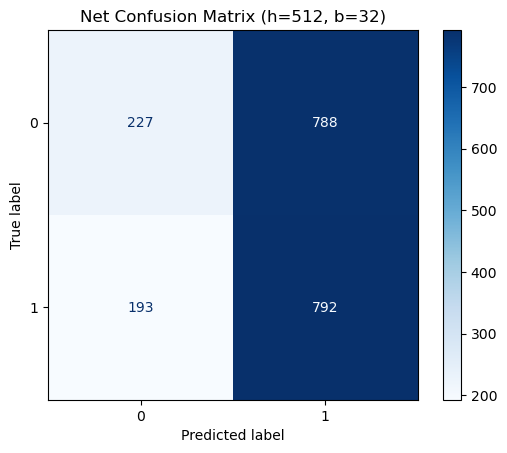

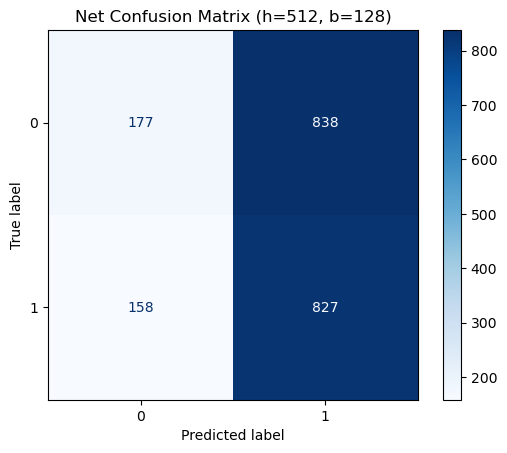

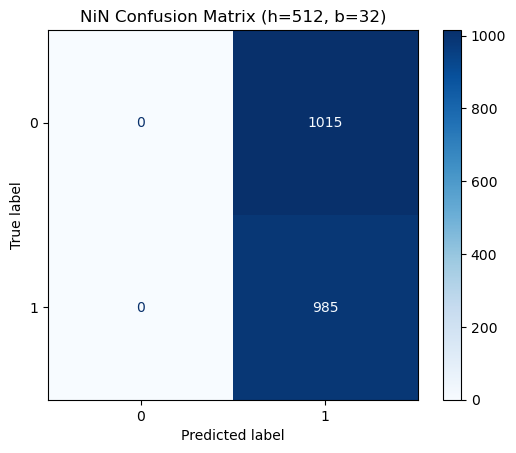

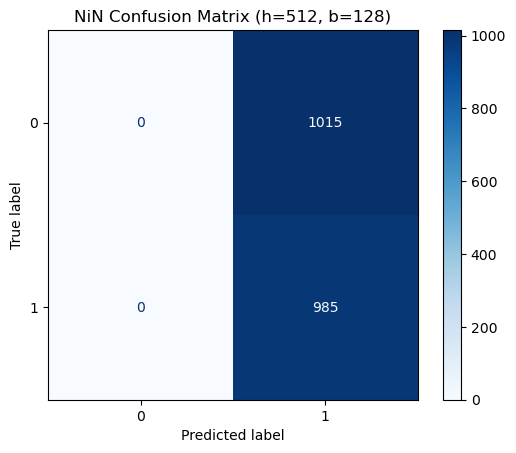

Running Net with hidden_dim=512, batch_size=32
Total training samples: 8000
Total testing samples: 2000
Epoch 1/5, Accuracy: 50.95%
Total training samples: 8000
Total testing samples: 2000
Epoch 2/5, Accuracy: 57.00%
Total training samples: 8000
Total testing samples: 2000
Epoch 3/5, Accuracy: 56.35%
Total training samples: 8000
Total testing samples: 2000
Epoch 4/5, Accuracy: 51.55%
Total training samples: 8000
Total testing samples: 2000
Epoch 5/5, Accuracy: 55.50%
Running Net with hidden_dim=512, batch_size=128
Total training samples: 8000
Total testing samples: 2000
Epoch 1/5, Accuracy: 50.75%
Total training samples: 8000
Total testing samples: 2000
Epoch 2/5, Accuracy: 55.80%
Total training samples: 8000
Total testing samples: 2000
Epoch 3/5, Accuracy: 55.45%
Total training samples: 8000
Total testing samples: 2000
Epoch 4/5, Accuracy: 56.10%
Total training samples: 8000
Total testing samples: 2000
Epoch 5/5, Accuracy: 56.00%
Running NiN with hidden_dim=512, batch_size=32
Total tr

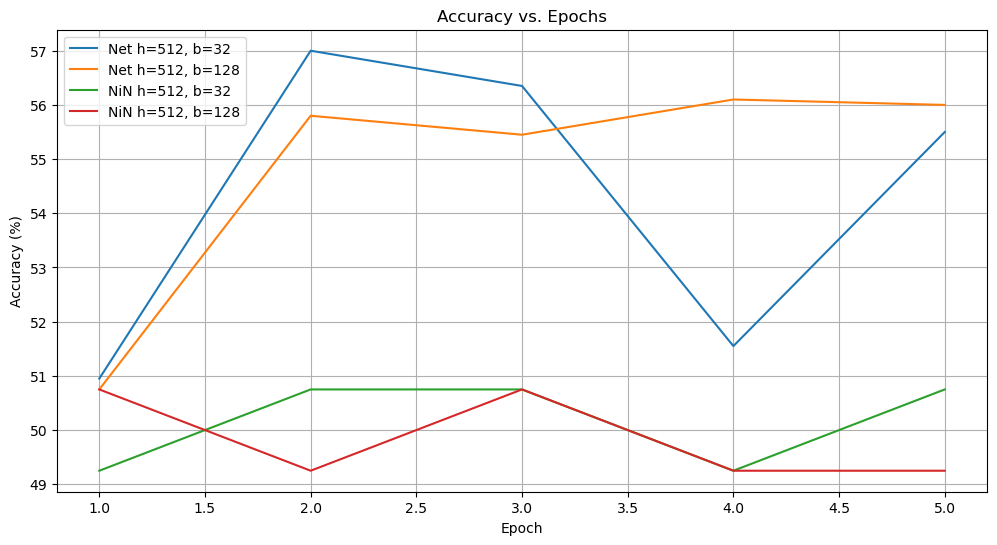

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to run experiments
def run_experiment_once(model_class, hidden_dim, batch_size, train_loader, test_loader, device):
    print(f"Running {model_class.__name__} with hidden_dim={hidden_dim}, batch_size={batch_size}")

    # Update train and test loaders with the new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, optimizer, and loss function
    model = model_class(hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.CrossEntropyLoss()

    # Train and test only once
    train(model, train_loader, optimizer, loss_fn, device)
    accuracy, y_true, y_pred = test(model, test_loader, device)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print(f"Confusion Matrix for {model_class.__name__} (h={hidden_dim}, b={batch_size}):")
    print(cm)
    print(f"Sum of Confusion Matrix Values: {cm.sum()}")

    # Return results
    return {
        "model_name": model_class.__name__,
        "hidden_dim": hidden_dim,
        "batch_size": batch_size,
        "accuracy": accuracy,
        "confusion_matrix": cm
    }

def run_experiment_epochs(model_class, hyperparameters, batch_sizes, train_loader, test_loader, device, epochs):
    results = []
    for hidden_dim in hyperparameters:
        for batch_size in batch_sizes:
            print(f"Running {model_class.__name__} with hidden_dim={hidden_dim}, batch_size={batch_size}")

            # Update train and test loaders with the new batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Initialize the model, optimizer, and loss function
            model = model_class(hidden_dim=hidden_dim).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.0005)
            loss_fn = nn.CrossEntropyLoss()

            # Train for multiple epochs and collect accuracies
            epoch_accuracies = []
            for epoch in range(epochs):
                train(model, train_loader, optimizer, loss_fn, device)
                accuracy, _, _ = test(model, test_loader, device)
                epoch_accuracies.append(accuracy)
                print(f"Epoch {epoch + 1}/{epochs}, Accuracy: {accuracy:.2f}%")

            # Store accuracy results
            results.append({
                "model_name": model_class.__name__,
                "hidden_dim": hidden_dim,
                "batch_size": batch_size,
                "accuracies": epoch_accuracies
            })
    return results

def plot_accuracy(results, epochs, title="Accuracy vs. Epochs"):
    plt.figure(figsize=(12, 6))

    # Plot each result
    for result in results:
        model_name = result["model_name"]
        hidden_dim = result["hidden_dim"]
        batch_size = result["batch_size"]
        accuracies = result["accuracies"]
        plt.plot(range(1, epochs + 1), accuracies, label=f"{model_name} h={hidden_dim}, b={batch_size}")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()

# Experiment settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5
hyperparameters = [512]  # Hidden layers
batch_sizes = [32, 128]   # Batch sizes

# Run experiments once for confusion matrices
confusion_results = []
for model_class in [Net, NiN]:
    for hidden_dim in hyperparameters:
        for batch_size in batch_sizes:
            result = run_experiment_once(model_class, hidden_dim, batch_size, train_loader, test_loader, device)
            confusion_results.append(result)

# Plot confusion matrices for individual experiments
for result in confusion_results:
    cm = result["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title(f"{result['model_name']} Confusion Matrix (h={result['hidden_dim']}, b={result['batch_size']})")
    plt.show()

# Run experiments for accuracy vs. epochs
accuracy_results = []
for model_class in [Net, NiN]:
    accuracy_results += run_experiment_epochs(model_class, hyperparameters, batch_sizes, train_loader, test_loader, device, epochs)

# Plot accuracy vs. epochs
plot_accuracy(accuracy_results, epochs)
